## Load in Packages

In [1]:
suppressPackageStartupMessages({ 
    library(data.table) 
    library(dplyr) 
    library(ggplot2) 
    library(SingleCellExperiment)
    library(dplyr)
    library(celldex)
    library(SingleR)
    library(RColorBrewer)
    library(scater) 
    library(StabMap) 
    library(scran) 
    library(harmony) 
    library(patchwork)
    library(Seurat)
    library(plotly)
    library(pheatmap)
    library(batchelor)
    library(ggpubr)
    library(cowplot)
    library(viridis)
    library(ggplot2)
    library(cowplot)
    library(grid)
    library(ragg) # For rasterized output
    library(ggplot2)
    library(Seurat)
    library(patchwork)
    library(cowplot)
    library(ragg)
    library(gridExtra)
    library(ggplot2)
    library(patchwork)
    library(Cairo)
    library(grid)
    library(png)
})

## Load in R Scripts that Contain Cell Type Colours Etc.

In [2]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

invisible(lapply(script_files, source))

## Data Locations

In [3]:
##### Load in Seurat Objects for post QC analyses #####

io = list()
io$main = "/rds/project/rds-SDzz0CATGms/users/ltgh2" # this is the main directory

# Set the working directory
setwd(io$main)

io$atlas = file.path(io$main, "projects/03_seqFISH_FINAL/code/extended_atlas_integration/processed_downsampled/downsample_10K_within_timpoint_all_stages.Rds")
io$seqFISH = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

##### Load in StabMAP_Outputs #####
io$StabMAP_reweighted_MNNcorrected_original_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_original_counts_without_neigh.Rds")
io$StabMAP_reweighted_MNNcorrected_integrated_counts_without_neigh = file.path(io$main, "projects/03_seqFISH_FINAL/code/stab_map_all_together_post_QC/output/StabMAP_allstages_postQC_reweighted_MNNcorrected_integrated_counts_without_neigh.Rds")

## Load in the seqFISH CellType Labels
io$seqFISH_labels = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_label_transfer/output/StabMAP_all_stages_post_QC_reweighted_MNNcorrected_original_counts_without_neigh_LABELS.Rds")

## Load in the seqFISH Imputed Gene Expression
io$seqFISH_imputed_logcounts_e6 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e6_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e7 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e7_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_1 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo1_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_2 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo2_postQC_imputed_RNA.Rds")

io$seqFISH_imputed_logcounts_e8_3 = file.path(io$main, 
                              "projects/03_seqFISH_FINAL/code/stabmap_imputation/output/seqFISH_e8_embryo3_postQC_imputed_RNA.Rds")

## Load in the seqFISH UMAP coordinates
io$UMAP_coordinates = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/stab_map_umap_generation/processed/StabMAP_allstage_postQC_MNNoriginal_UMAP.rds")

In [4]:
io$seqFISH_preQC = file.path(io$main, "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_and_across_dataset_integration_without_neighbour_features_E6_7_8.Rds") 

In [5]:
##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$timepoint_pre_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

io$timepoint_post_QC = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_dataset_integration_without_neighbour_features_E6_7_8.Rds")

In [6]:
##### Load in within timepoint integrated Seurat Objects for pre and post QC analyses #####
io$post_QC_early_embryos_ONLY = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/seqFISH_integration/processed/seqFISH_after_QC_filtering_within_and_across_dataset_integration_without_neighbour_features_E6_7_ONLY.Rds")

In [7]:
##### Load in the refined annotations and final metadata #####
io$FINAL_REFINED_ANNOTATIONS = file.path(io$main, 
                               "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/outputs/1B_FINAL_REFINED_ANNOTATIONS_REVISIONS_POST_REVISION.Rds")

## Load in Seurat Objects and to the Seurat Object add the StabMAP UMAP, Transferred Cell Type Labels and Imputed Gene Expression Matrix

In [8]:
# Load in the seqFISH object_postQC
seqFISH = readRDS(io$seqFISH)

# Load in celltype, stage and anatomy labels
seqFISH_labels = readRDS(io$seqFISH_labels)

# Update the colnames in the seqFISH meta.data
seqFISH_labels_updated <- seqFISH_labels
colnames(seqFISH_labels_updated) <- c("nearest_cell_label_transfer", "celltype_extended_atlas", "stage", "anatomy", "somite_count")


seqFISH <- AddMetaData(seqFISH, metadata = seqFISH_labels_updated)

# Load in the imputed gene expression 
seqFISH_imputed_logcounts_e6 = readRDS(io$seqFISH_imputed_logcounts_e6)
seqFISH_imputed_logcounts_e7 = readRDS(io$seqFISH_imputed_logcounts_e7)
seqFISH_imputed_logcounts_e8_1 = readRDS(io$seqFISH_imputed_logcounts_e8_1)
seqFISH_imputed_logcounts_e8_2 = readRDS(io$seqFISH_imputed_logcounts_e8_2)
seqFISH_imputed_logcounts_e8_3 = readRDS(io$seqFISH_imputed_logcounts_e8_3)

# Create a combined matrix of gene expression across all time points
imputed_expression <- cbind(seqFISH_imputed_logcounts_e6$scRNA.RNA, 
                           seqFISH_imputed_logcounts_e7$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_1$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_2$scRNA.RNA, 
                            seqFISH_imputed_logcounts_e8_3$scRNA.RNA)

# Creat a new assay object to store imputed data
imp <- CreateAssayObject(data = imputed_expression)

# add this assay to the previously created Seurat object
seqFISH[["imputed"]] <- imp

seqFISH_postQC <- seqFISH

seqFISH_postQC

An object of class Seurat 
28723 features across 63188 samples within 4 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 3 other assays present: originalexp, within_timepoint_integration, imputed
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [9]:
post_QC_early_embryos_ONLY <- readRDS(io$post_QC_early_embryos_ONLY)

In [10]:
# Load in the seqFISH object_postQC
atlas = readRDS(io$atlas)

In [11]:
seqFISH_preQC = readRDS(io$seqFISH_preQC)

In [12]:
seqFISH_preQC

An object of class Seurat 
1053 features across 73470 samples within 3 assays 
Active assay: across_timepoint_integration (351 features, 351 variable features)
 2 other assays present: originalexp, within_timepoint_integration
 5 dimensional reductions calculated: pca, umap, spatial, Shila_PCA, Shila_UMAP

In [13]:
# Load in the UMAP coordinates
UMAP_coordinates = readRDS(io$UMAP_coordinates)

# Load in the StabMAP coordinates
StabMAP_reweighted_MNNcorrected_original_counts_without_neigh = readRDS(io$StabMAP_reweighted_MNNcorrected_original_counts_without_neigh)

##Create dimension reduced objects to insert into the seuart object
StabMAP_original <- CreateDimReducObject(embeddings = StabMAP_reweighted_MNNcorrected_original_counts_without_neigh, 
                                         key = "StabMap.original",
                                         assay = "originalexp")

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from StabMap.original to StabMaporiginal_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to StabMaporiginal_”


In [14]:
# load in the final refined_annotations
FINAL_REFINED_ANNOTATIONS_UPDATED = readRDS(io$FINAL_REFINED_ANNOTATIONS)

In [15]:
FINAL_REFINED_ANNOTATIONS <- FINAL_REFINED_ANNOTATIONS_UPDATED %>% 
  select(-embryo)

In [16]:
colnames(FINAL_REFINED_ANNOTATIONS)

[1] "cell_ID"                                             
 [2] "orig.ident"                                          
 [3] "nCount_RNA"                                          
 [4] "nFeature_RNA"                                        
 [5] "seqFISH_celltype"                                    
 [6] "extended_atlas_celltype"                             
 [7] "AP"                                                  
 [8] "DV"                                                  
 [9] "dataset"                                             
[10] "cluster"                                             
[11] "subcluster"                                          
[12] "cluster_subcluster"                                  
[13] "stage"                                               
[14] "anatomy"                                             
[15] "UMAP_1"                                              
[16] "UMAP_2"                                              
[17] "celltype_PijuanSala2019"                             
[18] "majority_seqFISH_celltype"                           
[19] "majority_seqFISH_celltype_proportion"                
[20] "majority_extended_atlas_celltype"                    
[21] "majority_extended_atlas_celltype_proportion"         
[22] "majority_celltype_PijuanSala2019_celltype"           
[23] "majority_celltype_PijuanSala2019_celltype_proportion"
[24] "stage_transfer"                                      
[25] "poor_stage_alignment"                                
[26] "proportion_seqFISH_cells_per_subcluster"             
[27] "joint_clusters_pass_QC"                              
[28] "stage_alignment_pass_QC"                             
[29] "passed_QC"                                           
[30] "refined_annotation"

## Generate Individual Seurat Objects for seqFISH and scRNA

### Update the Embryo Labels in the Seurat Objects

In [17]:
update_embryo_names <- function(seurat_obj) {
    # Define the mapping for renaming embryos
    embryo_mapping <- c("embryo1" = "embryo_5",
                        "embryo2" = "embryo_6",
                        "embryo3" = "embryo_7",
                        "embryo6" = "embryo_1",
                        "embryo7" = "embryo_2",
                        "embryo4" = "embryo_3",
                        "embryo5" = "embryo_4")

    embryo_sf_mapping <- c("embryo1" = "5",
                           "embryo2" = "6",
                           "embryo3" = "7",
                           "embryo6" = "1",
                           "embryo7" = "2",
                           "embryo4" = "3",
                           "embryo5" = "4")

    # Update embryo names
    seurat_obj@meta.data$embryo_name_updated <- embryo_mapping[seurat_obj@meta.data$embryo]
    seurat_obj@meta.data$embryo_name_updated_sf <- embryo_sf_mapping[seurat_obj@meta.data$embryo]
    
    return(seurat_obj)
}

# Example usage:
seqFISH_preQC <- update_embryo_names(seqFISH_preQC)
#seurat_combined_seqFISH <- update_embryo_names(seurat_combined_seqFISH)

## Get Marker Genes List Organized

In [18]:
script_files <- list.files("projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/R_scripts", 
                           pattern = "\\.[rR]$", full.names = TRUE)

invisible(lapply(script_files, source))

In [19]:
# Flatten the list into a single character vector
all_marker_genes <- unlist(Imaz_Rosshandler_marker_genes)

# Print the result
str(all_marker_genes)

 Named chr [1:579] "Hoxa10" "Hoxa11" "Tbx2" "Tbx4" "Cdh5" "Hoxa11" "Plac1" ...
 - attr(*, "names")= chr [1:579] "Allantois1" "Allantois2" "Allantois3" "Allantois4" ...


In [20]:
# Remove the names from the vector
all_marker_genes <- unique(unname(all_marker_genes))

# Print the result
str(all_marker_genes)

 chr [1:315] "Hoxa10" "Hoxa11" "Tbx2" "Tbx4" "Cdh5" "Plac1" "Vcam1" "Aqp2" ...


## PIPELINE TO GENERATE SUPPLEMENTARY FIGURES CONNECTED TO MAIN FIGURE 2

#### getting Objects Ready

In [21]:
### LOAD IN DF_TOTAL ###
seqFISH_preQC <- AddMetaData(seqFISH_preQC, metadata = FINAL_REFINED_ANNOTATIONS)
seqFISH_preQC@meta.data$refined_annotation <- as.character(seqFISH_preQC@meta.data$refined_annotation)
seqFISH_preQC_updated <- seqFISH_preQC

# Replace NA with "failed_qc"
seqFISH_preQC_updated@meta.data$refined_annotation <- ifelse(
  is.na(seqFISH_preQC_updated@meta.data$refined_annotation),
  "failed_qc",
  seqFISH_preQC_updated@meta.data$refined_annotation
)

# add the spatial coordinates to the data.frame
spatial_coordinates <- as.data.frame(seqFISH_preQC_updated@reductions$spatial@cell.embeddings)
spatial_coordinates$cell_ID <- row.names(spatial_coordinates)

df <- seqFISH_preQC_updated@meta.data
df_total <- cbind(spatial_coordinates, df)

# Replace NA with "failed_qc"
df_total$refined_annotation <- ifelse(
  is.na(df_total$refined_annotation),
  "failed_qc",
  df_total$refined_annotation
)

In [22]:
dim(df_total)

[1] 73470    57

In [23]:
head(df)

,orig.ident,nCount_originalexp,nFeature_originalexp,dim1,dim2,dim3,sample_id,embryo,pos,fov,...,majority_extended_atlas_celltype_proportion,majority_celltype_PijuanSala2019_celltype,majority_celltype_PijuanSala2019_celltype_proportion,stage_transfer,poor_stage_alignment,proportion_seqFISH_cells_per_subcluster,joint_clusters_pass_QC,stage_alignment_pass_QC,passed_QC,refined_annotation
,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,...,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
embryo6_Pos0_cell2,embryo6,138,93,600.3434,125.1070,2.500691,sample01,embryo6,Pos0,fov.1,...,0.9444444,Anterior Primitive Streak,0.6777778,E7.25,FALSE,0.06666667,TRUE,TRUE,TRUE,Anterior Primitive Streak
embryo6_Pos0_cell3,embryo6,50,37,429.2308,210.4952,3.504292,sample01,embryo6,Pos0,fov.1,...,0.7821429,New cells,0.7178571,E8.75,TRUE,0.34285714,TRUE,FALSE,FALSE,Migratory neural crest
embryo6_Pos0_cell4,embryo6,120,59,439.7686,221.7524,4.922626,sample01,embryo6,Pos0,fov.1,...,0.6019417,Epiblast,0.6601942,E7.25,FALSE,0.89320388,TRUE,TRUE,TRUE,Epiblast
embryo6_Pos0_cell5,NA,28,23,413.1775,197.8247,1.840986,sample01,embryo6,Pos0,fov.1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell6,NA,16,10,436.8529,202.6335,5.505245,sample01,embryo6,Pos0,fov.1,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell7,embryo6,87,48,440.2362,164.0092,1.508630,sample01,embryo6,Pos0,fov.1,...,0.9482440,Epiblast,0.9667283,E7.25,FALSE,0.04621072,TRUE,TRUE,TRUE,Epiblast


In [24]:
head(df_total)

,dim_1,dim_2,dim_3,cell_ID,orig.ident,nCount_originalexp,nFeature_originalexp,dim1,dim2,dim3,...,majority_extended_atlas_celltype_proportion,majority_celltype_PijuanSala2019_celltype,majority_celltype_PijuanSala2019_celltype_proportion,stage_transfer,poor_stage_alignment,proportion_seqFISH_cells_per_subcluster,joint_clusters_pass_QC,stage_alignment_pass_QC,passed_QC,refined_annotation
,<dbl>,<dbl>,<dbl>,<chr>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,...,<dbl>,<chr>,<dbl>,<chr>,<lgl>,<dbl>,<lgl>,<lgl>,<lgl>,<chr>
embryo6_Pos0_cell2,600.3434,125.1070,2.500691,embryo6_Pos0_cell2,embryo6,138,93,600.3434,125.1070,2.500691,...,0.9444444,Anterior Primitive Streak,0.6777778,E7.25,FALSE,0.06666667,TRUE,TRUE,TRUE,Anterior Primitive Streak
embryo6_Pos0_cell3,429.2308,210.4952,3.504292,embryo6_Pos0_cell3,embryo6,50,37,429.2308,210.4952,3.504292,...,0.7821429,New cells,0.7178571,E8.75,TRUE,0.34285714,TRUE,FALSE,FALSE,Migratory neural crest
embryo6_Pos0_cell4,439.7686,221.7524,4.922626,embryo6_Pos0_cell4,embryo6,120,59,439.7686,221.7524,4.922626,...,0.6019417,Epiblast,0.6601942,E7.25,FALSE,0.89320388,TRUE,TRUE,TRUE,Epiblast
embryo6_Pos0_cell5,413.1775,197.8247,1.840986,embryo6_Pos0_cell5,NA,28,23,413.1775,197.8247,1.840986,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell6,436.8529,202.6335,5.505245,embryo6_Pos0_cell6,NA,16,10,436.8529,202.6335,5.505245,...,NA,NA,NA,NA,NA,NA,NA,NA,NA,failed_qc
embryo6_Pos0_cell7,440.2362,164.0092,1.508630,embryo6_Pos0_cell7,embryo6,87,48,440.2362,164.0092,1.508630,...,0.9482440,Epiblast,0.9667283,E7.25,FALSE,0.04621072,TRUE,TRUE,TRUE,Epiblast


In [25]:
# Example usage:
df_total$embryo_name_updated <- recode(df_total$embryo,
                        "embryo1" = "embryo_5",
                        "embryo2" = "embryo_6",
                        "embryo3" = "embryo_7",
                        "embryo6" = "embryo_1",
                        "embryo7" = "embryo_2",
                        "embryo4" = "embryo_3",
                        "embryo5" = "embryo_4")

df_total$embryo_name_updated_sf <- recode(df_total$embryo,
                           "embryo1" = "5",
                           "embryo2" = "6",
                           "embryo3" = "7",
                           "embryo6" = "1",
                           "embryo7" = "2",
                           "embryo4" = "3",
                           "embryo5" = "4")

In [26]:
table(df_total$embryo_name_updated_sf, useNA = "ifany")


    1     2     3     4     5     6     7 
 3811  4355  4545  2083 19566 14941 24169 

## Scatter Plot of Average Cell Type Position in AP/DV Axis

In [27]:
# Define the subset of labels you want to display
labels_to_display <- c("Allantois", "Allantois endothelium", "Anterior cardiopharyngeal progenitors",
               "Anterior somitic tissues",
               "Branchial arch neural crest", "Cardiomyocytes FHF 1", "Cardiomyocytes FHF 2", "Epicardium",
               "Caudal epiblast", "Notochord",
               "Cranial mesoderm", "Dorsal hindbrain progenitors", "Dorsal spinal cord progenitors",
               "Ectoderm", "Embryo proper endothelium",
               "Foregut", "Hindbrain neural progenitors",
               "Hindgut", "Somitic mesoderm", "Gut tube",
               "Midbrain/Hindbrain boundary", "Pharyngeal mesoderm", "Placodal ectoderm",
               "Posterior somitic tissues", "Sclerotome", "Ventral forebrain progenitors") # Replace with the labels you want to display

In [28]:
# Subset to only necessary columns
df_subset <- subset(df_total, select = c(refined_annotation, AP, DV))

# Group and summarize
average_values_scRNA <- df_subset %>%
  group_by(refined_annotation) %>%
  summarise(avg_AP = mean(AP, na.rm = TRUE),
            avg_DV = mean(DV, na.rm = TRUE),
            sd_AP = sd(AP, na.rm = TRUE),
            sd_DV = sd(DV, na.rm = TRUE),
            .groups = 'drop') %>%
  mutate(sd_sum = sd_AP + sd_DV)

# Define axis limits
x_range <- c(0, 100)
y_range <- c(0, 100)

# Create scatter plot
scatter_plot <- ggplot(average_values_scRNA, aes(x = avg_DV, y = avg_AP)) +
  geom_point(aes(color = refined_annotation, size = sd_sum)) +
  geom_text(data = subset(average_values_scRNA, refined_annotation %in% labels_to_display),
            aes(label = refined_annotation),  # <- Corrected label
            nudge_y = 3, family = "Helvetica", size = 4) +
  scale_color_manual(values = Harland_colors) +  # <- assumes Harland_colors is named vector
  coord_fixed(1, xlim = x_range, ylim = y_range) +
  theme(
    panel.background = element_rect(fill = "transparent"),
    panel.grid.major = element_line(color = "black"),
    panel.grid.minor = element_blank(),
    text = element_text(family = "Helvetica", size = 20),
    legend.position = "none",
    axis.line = element_line(color = "black", size = 0.5)
  )

width = 10
height = 10
# Save the grid plot as .svg file to specific file path
ggsave(filename = "projects/03_seqFISH_FINAL/code/CELL_GENOMICS_REVISIONS/GITHUB_UPLOAD_FOLDER/6_figure_generation/fig_3_and_sfig_7/output/seqFISH_scatter_plot.svg", 
      plot = scatter_plot, 
      device = "svg",
      width = width,
      height = height)

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”


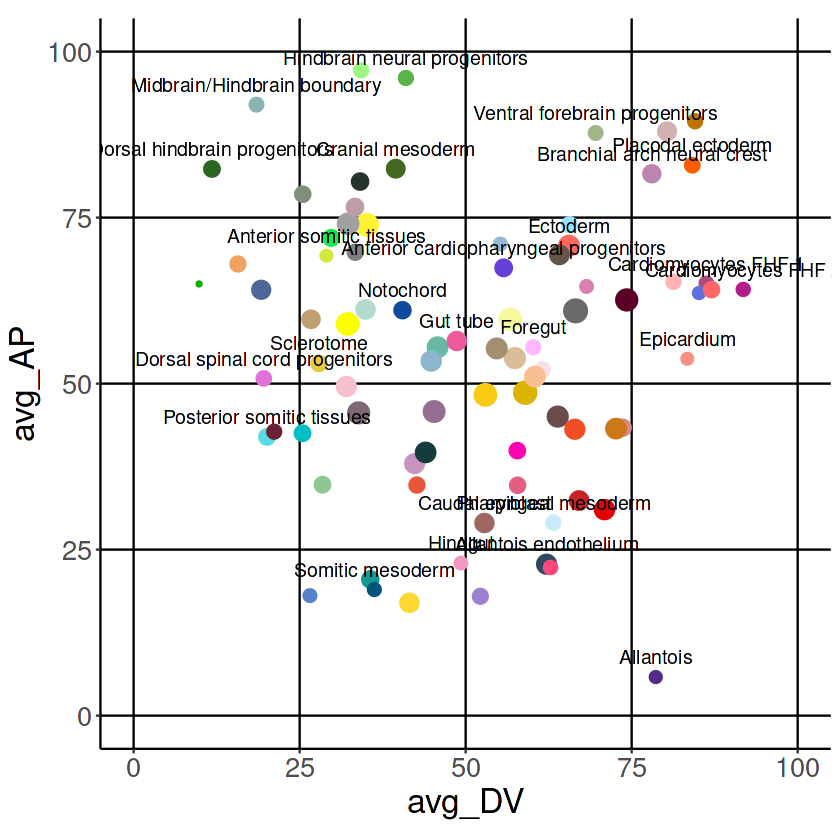

In [29]:
scatter_plot

## Print out Package Versions

In [30]:
sessionInfo()

R version 4.2.1 (2022-06-23)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] grid      stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] png_0.1-8                   Cairo_1.6-0                
 [3] gridExtra_2.3               ragg_1.2.2                 
 [5] viridis_0.6.2               viridisLite_0.4.1          
 [7] cowplot_1.1.1               ggpubr_0.4.0               
 [9] batchelor_1.12.3            pheatmap_1.0.12            
[11] plotly_4.10.0 